In [3]:
import sys, os, ndreg, skimage
import matplotlib.pyplot as plt
from matplotlib import cm
from ndreg import preprocessor, registerer
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import missing_data_sim as mdmask
import ingest_tif_stack as ingest

In [4]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# Setup Data

In [7]:
resolution = 50

In [8]:
rmt = BossRemote(cfg_file_or_dict='./intern.cfg')
atlas = ndreg.download_ara(rmt, resolution)
atlas_mask = preprocessor.create_mask(atlas, use_triangle=True)
atlas_width, atlas_height, atlas_depth = atlas.GetSize()

In [9]:
img = ndreg.download_image(rmt, 'ailey-dev', 'Insula_Atenolol-1_171204_new', 'Ch0', res=3)
img_width, img_height, img_depth = img.GetSize()

In [10]:
print('atlas width: {}, height: {}, depth: {}'.format(atlas_width, atlas_height, atlas_depth))
print('img width: {}, height: {}, depth: {}'.format(img_width, img_height, img_depth))

atlas width: 264, height: 160, depth: 228
img width: 270, height: 320, depth: 160


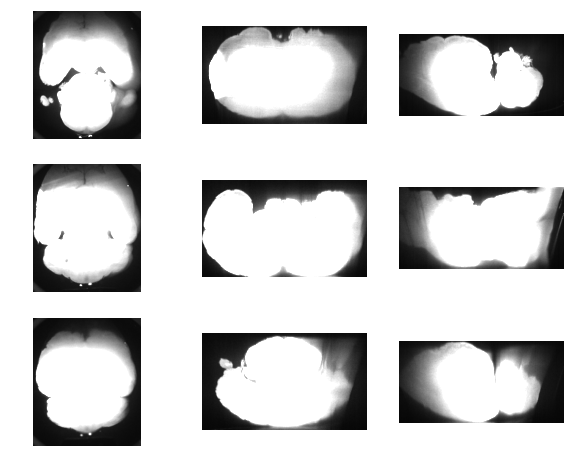

In [11]:
ndreg.imgShow(img, vmax=2500)

# Create missing data images

In [13]:
# 1/2 mask
half_array = gen_missing_hemisphere(img_depth, img_height, img_width, 0.5)
half_mask = mdmask.convert_to_image(half_array.astype('uint16'))
half_mask.CopyInformation(img)

# Missing anterior 
no_ant_array = gen_missing_anterior(img_depth, img_height, img_width, 0.2)
no_ant_mask = mdmask.convert_to_image(no_ant_array.astype('uint16'))
no_ant_mask.CopyInformation(img)

In [14]:
# 1/2 img
half_img = mdmask.mask_img(img, half_mask)
half_img = sitk.GetImageFromArray(sitk.GetArrayFromImage(half_img)[:,:,int(img_width*0.5):])
half_img.SetSpacing(img.GetSpacing())

# no ant img
no_ant_img = mdmask.mask_img(img, no_ant_mask)
no_ant_img = sitk.GetImageFromArray(sitk.GetArrayFromImage(no_ant_img)[:,int(img_height*0.2):,:])
no_ant_img.SetSpacing(img.GetSpacing())

# full img
full_img = sitk.Image(img)

In [65]:
print(no_ant_img.GetSize())

(270, 256, 160)


In [67]:
sitk.WriteImage(no_ant_img, './ingest_brain.img')

In [69]:
%run -i ingest_tif_stack.py -collection=missing_data_registration -experiment=missing_ant_insula_to_whole_atas -channel=Ch0 -img_stack=./ingest_brain.img -fmt=img --dtype=uint16 --config=./intern.cfg --new_channel=True



True
uploading image to boss...
uint16
(0, [0, 270], [0, 256], [0, 16])
(0, [0, 270], [0, 256], [16, 32])
(0, [0, 270], [0, 256], [32, 48])
(0, [0, 270], [0, 256], [48, 64])
(0, [0, 270], [0, 256], [64, 80])
(0, [0, 270], [0, 256], [80, 96])
(0, [0, 270], [0, 256], [96, 112])
(0, [0, 270], [0, 256], [112, 128])
(0, [0, 270], [0, 256], [128, 144])
(0, [0, 270], [0, 256], [144, 160])
upload done! to see upload go to this link: http://ben-dev.neurodata.io:8001/ndviz_url/missing_data_registration/missing_ant_insula_to_whole_atas/Ch0/


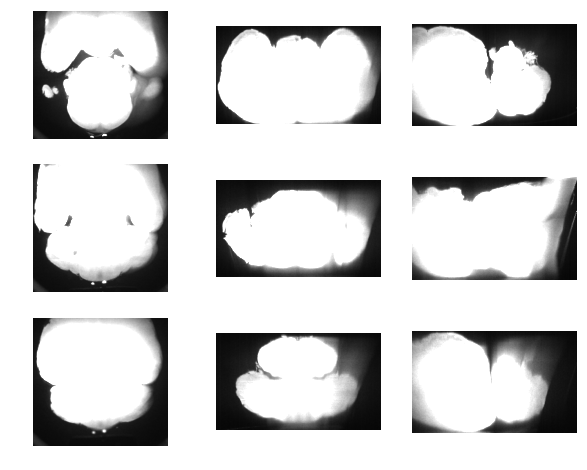

In [15]:
ndreg.imgShow(no_ant_img, vmax=2500)

In [66]:
print(half_img.GetSize())

(135, 320, 160)


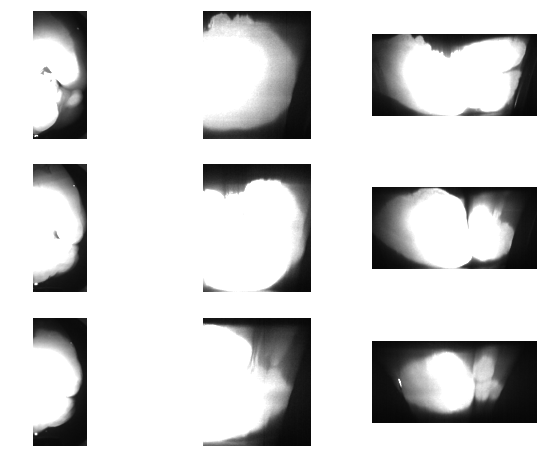

In [16]:
ndreg.imgShow(half_img, vmax=2500)

# Missing data padding

In [17]:
def pad_img_with_range(img, depth_range, height_range, width_range, return_mask=True):
    ''' User inputs the known padding parameters '''
    img_width, img_height, img_depth = img.GetSize()
    padded_img_width, padded_img_height, padded_img_depth = img_width+sum(width_range), img_height+sum(height_range), img_depth+sum(depth_range)
    padded_array = np.zeros((padded_img_depth, padded_img_height, padded_img_width))

    
    padded_array[depth_range[0]:(padded_img_depth-depth_range[1]), \
               height_range[0]:(padded_img_height-height_range[1]), \
               width_range[0]:(padded_img_width-width_range[1])] = sitk.GetArrayFromImage(img)
    padded_img = sitk.GetImageFromArray(padded_array)
    padded_img.SetSpacing(img.GetSpacing())
    
    if return_mask:
        padded_mask = np.zeros((padded_img_depth, padded_img_height, padded_img_width), dtype=np.uint16)
        padded_mask[depth_range[0]:(padded_img_depth-depth_range[1]), \
               height_range[0]:(padded_img_height-height_range[1]), \
               width_range[0]:(padded_img_width-width_range[1])] = 1
        padded_mask = sitk.GetImageFromArray(padded_mask)
        padded_mask.SetSpacing(img.GetSpacing())
        return padded_img, padded_mask
    return padded_img

### Padded with range

In [19]:
no_ant_img_width, no_ant_img_height, no_ant_img_depth = no_ant_img.GetSize()
padded_range_no_ant_img, padded_range_no_ant_mask = pad_img_with_range(no_ant_img, (0,0), (img_height-no_ant_img_height,0), (0, 0))
# assert padded_range_no_ant_img.GetSize() == img.GetSize()

half_img_width, half_img_height, half_img_depth = half_img.GetSize()
padded_range_half_img, padded_range_half_mask = pad_img_with_range(half_img, (0,0), (0, 0), (img_width - half_img_width,0))
# assert padded_range_half_img.GetSize() == img.GetSize()


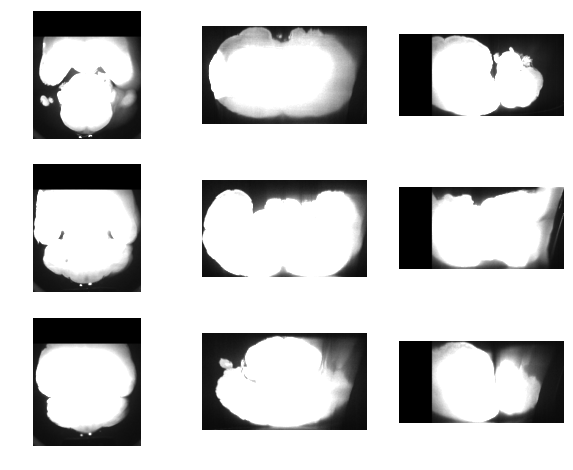

In [20]:
ndreg.imgShow(padded_range_no_ant_img, vmax=2500)

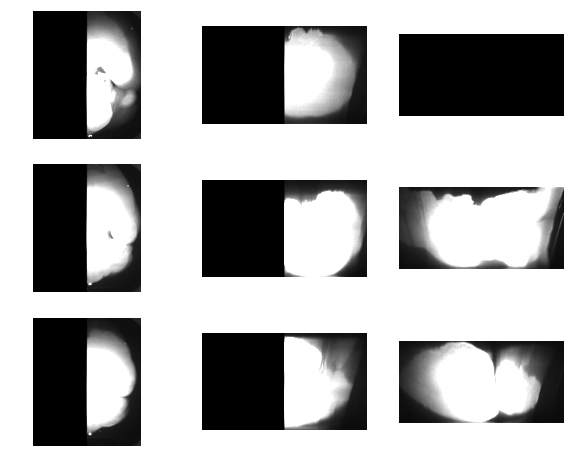

In [21]:
ndreg.imgShow(padded_range_half_img, vmax=2500)

# Registration

In [34]:
def downsample(img, res=3):
    out_spacing = np.array(img.GetSpacing()) * (2.0**res)
    img_ds = skimage.measure.block_reduce(sitk.GetArrayViewFromImage(img),
                                          block_size=(2,2,2), func=np.mean)
    for i in range(res - 1):
        img_ds = skimage.measure.block_reduce(img_ds, block_size=(2,2,2), func=np.mean)
    img_ds_sitk = sitk.GetImageFromArray(img_ds)
    img_ds_sitk.SetSpacing(out_spacing)
    return img_ds_sitk

In [35]:
mm_to_um = 1000.0
resolution_atlas = 50
orientation_atlas = 'pir'
orientation_image = 'lps'

rmt = BossRemote(cfg_file_or_dict='./intern.cfg')
img = padded_range_half_img
mask = padded_range_half_mask
atlas = ndreg.download_ara(rmt, resolution_atlas, type='average')

# img = ndreg.imgResample(img, [resolution_atlas/mm_to_um]*3)

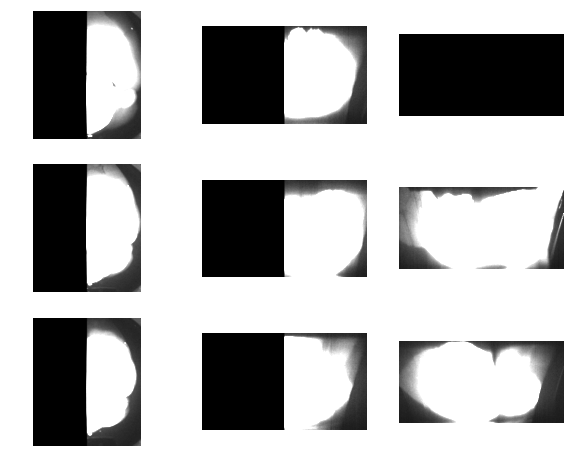

In [72]:
ndreg.imgShow(img, vmin=0, vmax=1000)

## Bias correction

In [38]:
mask_dilation_radius = 10 # voxels
mask_bc = sitk.BinaryDilate(preprocessor.create_mask(img, use_triangle=True), mask_dilation_radius)
img_bc, bias = preprocessor.correct_bias_field(img, scale=0.25, spline_order=4, mask=mask,
                                         num_control_pts=[5,5,5],
                                         niters=[50, 50, 50, 50])

In [40]:
img_bc = ndreg.imgReorient(img_bc, orientation_image, orientation_atlas)
mask = ndreg.imgReorient(mask, orientation_image, orientation_atlas)

atlas_n = sitk.Normalize(atlas)
img_bc_n = sitk.Normalize(img_bc)

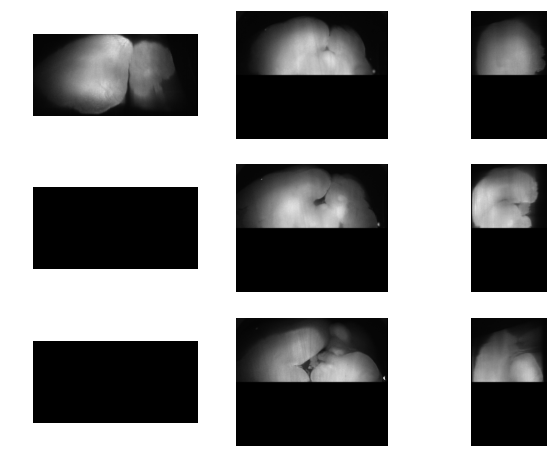

In [41]:
ndreg.imgShow(img_bc_n, vmax=4)

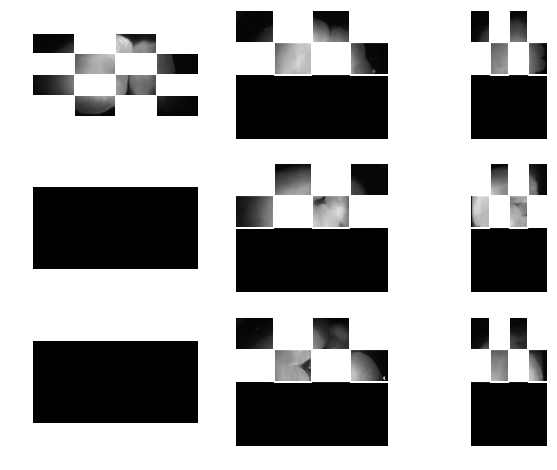

In [42]:
ndreg.imgShow(ndreg.imgChecker(mask, img_bc_n), vmax=4)

## Rigid registration

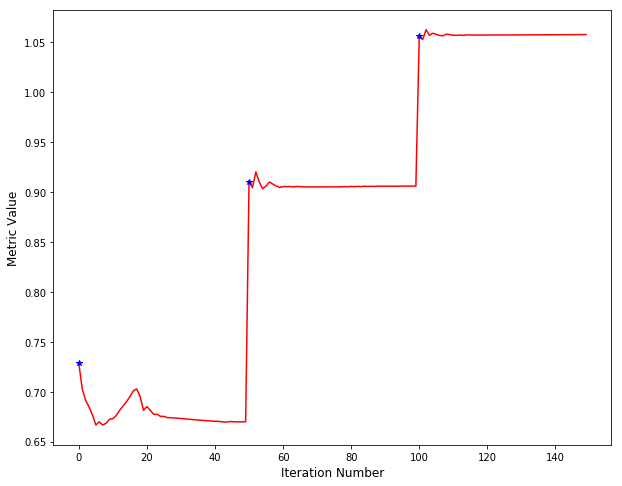

In [44]:
tmp_mask = sitk.BinaryDilate(preprocessor.create_mask(img, use_triangle=True), mask_dilation_radius)

# Inverse transform from image to atlas
final_transform = register_rigid(img_bc_n, 
                                            atlas_n,
                                            fixed_mask=mask,
                                            learning_rate=1e-1,
                                            grad_tol=4e-6,
                                            use_mi=False,
                                            iters=50,
                                            shrink_factors=[4,2,1],
                                            sigmas=[0.4, 0.2, 0.1],
                                            verbose=True)import sys, random, ndreg
import numpy as np
import SimpleITK as sitk
import skimage
from ndreg import preprocessor
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

    
def plot_mse(img1, img2, blend=0.2, color_blend=False):
    height, width = img1.shape
    overlap = np.zeros((height, width)) if not color_blend else np.zeros((height, width, 3))
    if not color_blend:
        for i in range(height):
            for j in range(width):
                grey = img1[i,j]*blend + img2[i,j]*blend
                overlap[i,j] = grey
    else:
        img1 = img1 + abs(np.amin(img1))
        img2 = img2 + abs(np.amin(img2))
        img1_max = np.amax(img1)
        img2_max = np.amax(img2)
        for i in range(height):
            for j in range(width):
                overlap[i,j,:] = (int(img1[i,j]/img1_max * 255), int(img2[i,j]/img2_max * 255), 0)
        
#         print(np.unique(overlap))

    x_errors = []
    for j in range(width):
        error = np.sqrt(np.sum(np.square(img1[:,j] - img2[:,j])))
        x_errors.append(error)
    x_errors = np.log(np.array(x_errors))

    y_errors = []
    for i in range(height):
        error = np.sqrt(np.sum(np.square(img1[i,:] - img2[i,:])))
        y_errors.append(error)
    y_errors = np.log(np.array(y_errors))

    gs = gridspec.GridSpec(5, 5, wspace=0.5, hspace=1)

    ax1 = plt.subplot(gs[:4, 0])
    ax2 = plt.subplot(gs[:4, 1:])
    ax3 = plt.subplot(gs[4, 1:])

    ax1.plot(y_errors, range(height))
    ax1.invert_yaxis()
    ax1.set_xlabel('Log MSE',fontsize=11)
    ax1.set_ylabel('Row pixel', fontsize=11)

    ax3.plot(range(width), x_errors)
    ax3.set_xlabel('Column pixel',fontsize=11)
    ax3.set_ylabel('Log MSE', fontsize=11)
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()


    ax2.imshow(overlap, aspect='auto')
    ax2.grid(True)

In [45]:
atlas_rigid = registerer.resample(atlas, final_transform.GetInverse(), img_bc, default_value=ndreg.imgPercentile(atlas,0.01))

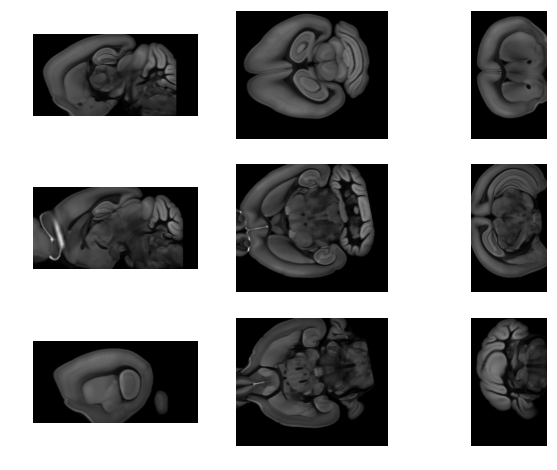

In [46]:
ndreg.imgShow(atlas_rigid)

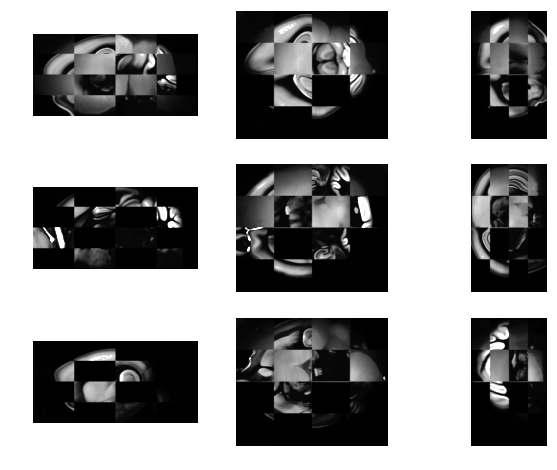

In [47]:
ndreg.imgShow(ndreg.imgChecker(atlas_rigid, img_bc_n), vmax=4)

## Affine registration

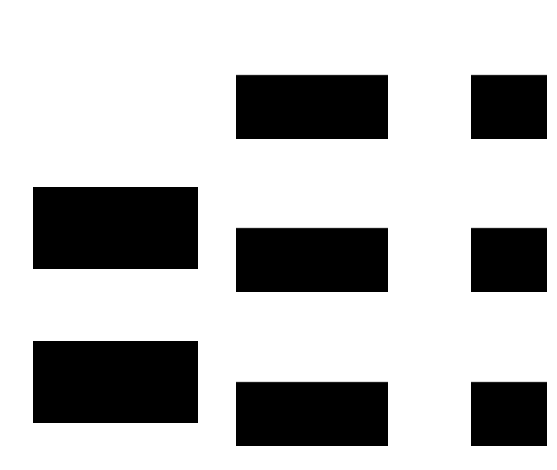

In [91]:
ndreg.imgShow(mask)

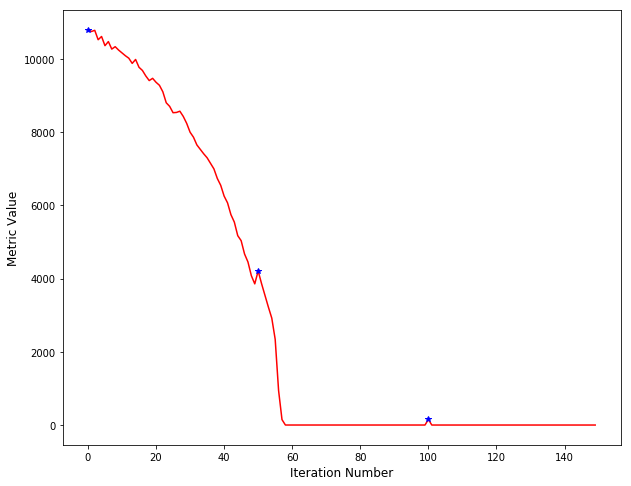

In [48]:
final_transform = registerer.register_affine(atlas_rigid, 
                                            img_bc_n,
                                            ref_mask=mask,
                                            learning_rate=1e-1,
                                            grad_tol=4e-6,
                                            use_mi=False,
                                            iters=50,
                                            shrink_factors=[4,2,1],
                                            sigmas=[0.4, 0.2, 0.1],
                                            verbose=True)

In [49]:
atlas_affine = registerer.resample(atlas_rigid, final_transform, img_bc, default_value=ndreg.imgPercentile(atlas,0.01))
target_affine = registerer.resample(img_bc, final_transform.GetInverse(), atlas, default_value=ndreg.imgPercentile(img_bc,0.01))


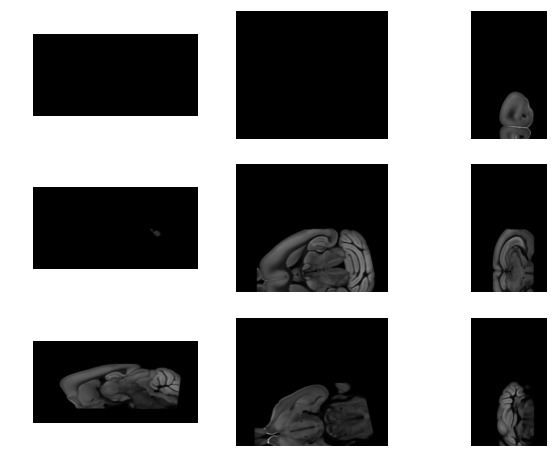

In [50]:
ndreg.imgShow(atlas_affine)

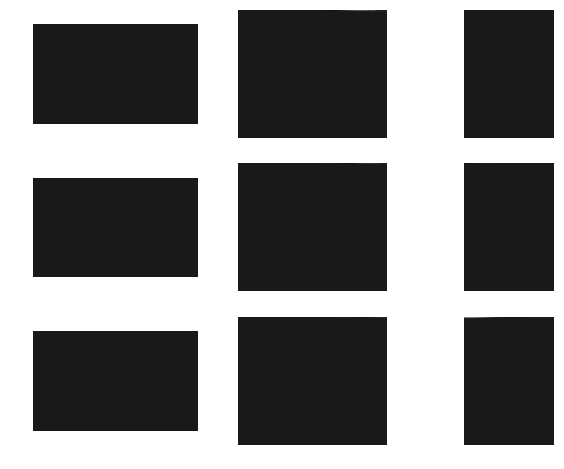

In [53]:
ndreg.imgShow(target_affine)

In [73]:
# whiten the images
print("whitening images...")
atlas_affine_w = sitk.AdaptiveHistogramEqualization(atlas_rigid, [10,10,10], alpha=0.25, beta=0.25)
img_bc_w = sitk.AdaptiveHistogramEqualization(img_bc, [10,10,10], alpha=0.25, beta=0.25)

whitening images...


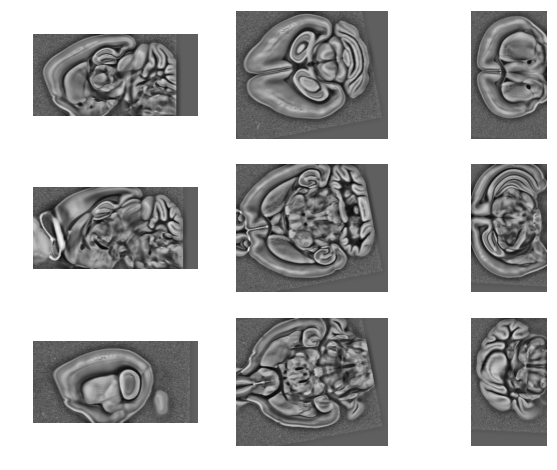

In [74]:
ndreg.imgShow(atlas_affine_w)

In [77]:
# lddmm code
print("beginning LDDMM parameter sweep")
e = 5e-3
s = 0.1
atlas_lddmm, field, inv_field = register_lddmm(affine_img=sitk.Normalize(atlas_affine_w), 
                                                          target_img=sitk.Normalize(img_bc_w),
                                                          refMask=mask,
                                                          alpha_list=[0.05], 
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=e, sigma=s,
                                                          min_epsilon_list=e*1e-6,
                                                          use_mi=False, iterations=50, verbose=True)

beginning LDDMM parameter sweep

Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	96089.7, 53.3984, 0, 96036.3 (98.2601%), 2.750000e-03
1.	88741.6, 86.0365, 0, 88655.6 (90.7085%), 3.025000e-03
2.	87389.2, 99.2579, 0, 87289.9 (89.3112%), 8.318750e-04
3.	85382.7, 116.641, 0, 85266.1 (87.2405%), 9.150625e-04
4.	85157.1, 127.614, 0, 85029.5 (86.9983%), 5.032844e-04
5.	84107, 141.219, 0, 83965.8 (85.9101%), 5.536128e-04
6.	83883.2, 149.045, 0, 83734.2 (85.6731%), 3.044870e-04
7.	83879, 153.476, 0, 83725.5 (85.6642%), 1.674679e-04
8.	83610.7, 158.534, 0, 83452.1 (85.3845%), 1.842147e-04
9.	83567.3, 159.904, 0, 83407.4 (85.3387%), 5.065903e-05
10.	83522.3, 161.429, 0, 83360.9 (85.2911%), 5.572494e-05
11.	83475.8, 163.12, 0, 83312.7 (85.2418%), 6.129743e-05
12.	83424, 164.988, 0, 83259 (85.1869%), 6.742717e-05
13.	83393.4, 166.017, 0, 83227.4 (85.1545%), 3.708494e-05
14.	83360.2, 167.156, 0, 83193 (85.1194%), 4.079344e-05
15.	83359.9, 167


Step 4: alpha=0.05, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	60912.4, 2.94908, 0, 60909.5 (96.6445%), 5.500000e-03
1.	60457.3, 2.33343, 0, 60455 (95.9234%), 3.025000e-03
2.	60448.9, 2.62686, 0, 60446.3 (95.9096%), 8.318750e-04
E = 60448.9 (95.9096%)
Length = 2.18256
Time = 691.084s (11.5181m)


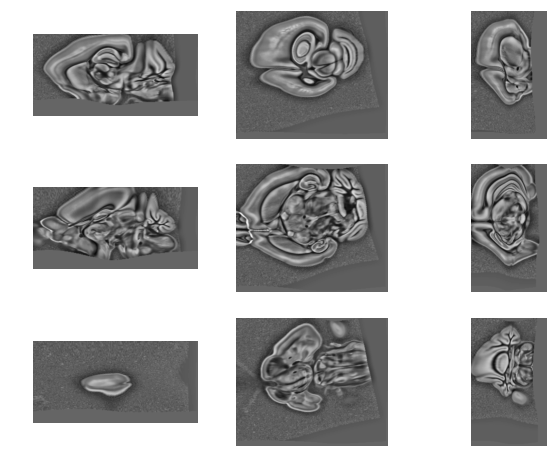

In [79]:
ndreg.imgShow(atlas_lddmm)

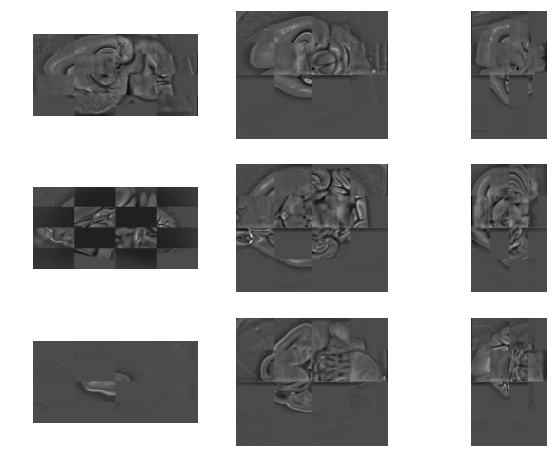

In [78]:
ndreg.imgShow(ndreg.imgChecker(atlas_lddmm, img_bc_w))

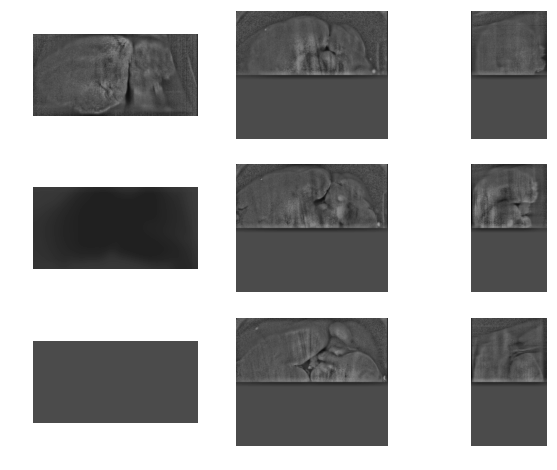

In [84]:
ndreg.imgShow(img_bc_w)

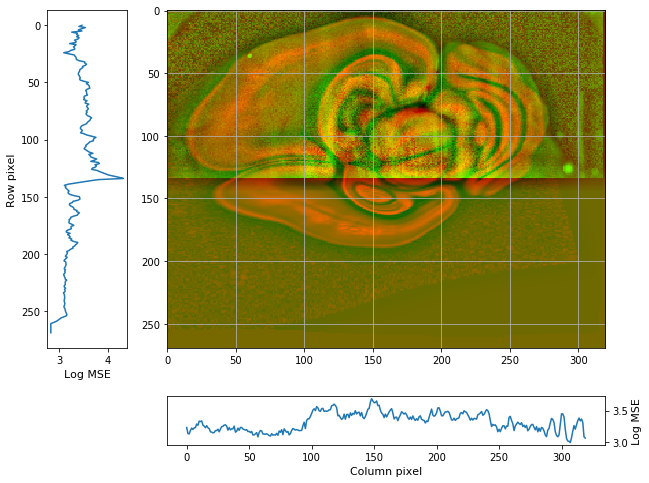

In [83]:
plot_mse(sitk.GetArrayFromImage(sitk.Normalize(atlas_lddmm))[:,50,:], sitk.GetArrayFromImage(sitk.Normalize(img_bc_w))[:,50,:], color_blend=True)


# No whitening

In [85]:
# lddmm code
e = 5e-3
s = 0.1
atlas_lddmm, field, inv_field = register_lddmm(affine_img=sitk.Normalize(atlas_rigid), 
                                                          target_img=sitk.Normalize(img_bc),
                                                          refMask=mask,
                                                          alpha_list=[0.05], 
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=e, sigma=s,
                                                          min_epsilon_list=e*1e-6,
                                                          use_mi=False, iterations=50, verbose=True)


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	57183.4, 49.3922, 0, 57134 (95.3262%), 5.500000e-03
1.	56154.7, 148.814, 0, 56005.9 (93.4439%), 6.050000e-03
2.	53716.9, 224.197, 0, 53492.7 (89.2507%), 6.655000e-03
3.	53373.4, 278.583, 0, 53094.8 (88.5868%), 3.660250e-03
4.	52967, 349.082, 0, 52617.9 (87.7912%), 4.026275e-03
5.	52173.7, 444.837, 0, 51728.8 (86.3078%), 4.428903e-03
6.	51374.6, 563.778, 0, 50810.8 (84.7761%), 4.871793e-03
7.	51290.7, 623.005, 0, 50667.7 (84.5373%), 2.679486e-03
8.	51237.2, 692.953, 0, 50544.3 (84.3314%), 2.947435e-03
9.	50963.5, 771.294, 0, 50192.2 (83.7439%), 3.242178e-03
10.	50607.9, 860.357, 0, 49747.5 (83.002%), 3.566396e-03
11.	50046.1, 965.438, 0, 49080.7 (81.8894%), 3.923035e-03
12.	49529.6, 1092.42, 0, 48437.2 (80.8157%), 4.315339e-03
13.	49169.7, 1252.78, 0, 47917 (79.9478%), 4.746873e-03
14.	48956.7, 1446.46, 0, 47510.3 (79.2693%), 5.221560e-03
15.	48636, 1688.72, 0, 46947.3 (78.3299%), 5

Length = 22.1246
Time = 3723.86s (62.0643m)


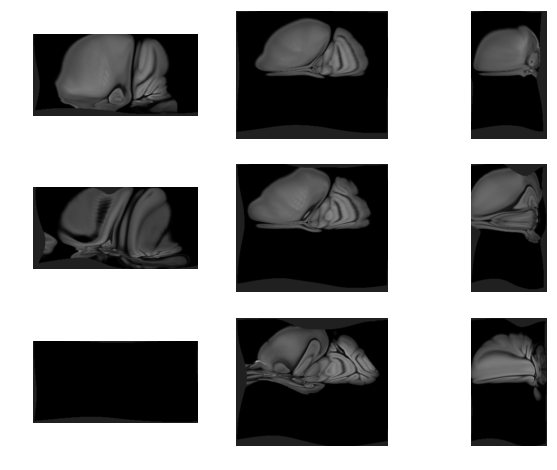

In [86]:
ndreg.imgShow(atlas_lddmm)

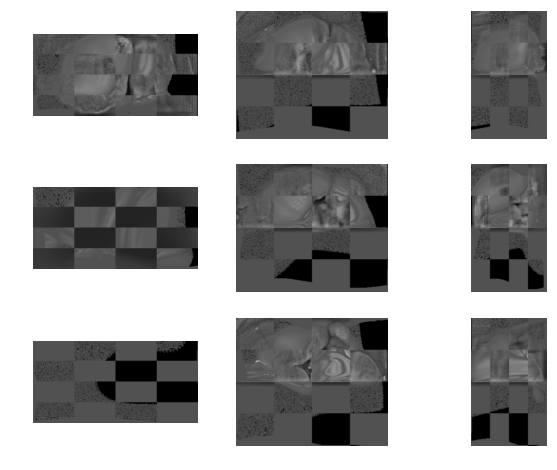

In [87]:
ndreg.imgShow(ndreg.imgChecker(atlas_lddmm, img_bc_w))

In [ ]:
plot_mse(sitk.GetArrayFromImage(sitk.Normalize(atlas_lddmm))[:,50,:], sitk.GetArrayFromImage(sitk.Normalize(img_bc_w))[:,50,:], color_blend=True)

In [89]:
sitk.WriteImage(sitk.Normalize(atlas_lddmm), './results.img')

In [90]:
%run -i ingest_tif_stack.py -collection=missing_data_registration \
-experiment=missing_insula_atenolol_registration_results \
-channel=half_rigid_no_whiten \
-img_stack=./results.img \
-fmt=img --dtype=uint16 --config=./intern.cfg --new_channel=True



True
uploading image to boss...
uint16
(0, [0, 320], [0, 160], [0, 16])
(0, [0, 320], [0, 160], [16, 32])
(0, [0, 320], [0, 160], [32, 48])
(0, [0, 320], [0, 160], [48, 64])
(0, [0, 320], [0, 160], [64, 80])
(0, [0, 320], [0, 160], [80, 96])
(0, [0, 320], [0, 160], [96, 112])
(0, [0, 320], [0, 160], [112, 128])
(0, [0, 320], [0, 160], [128, 144])
(0, [0, 320], [0, 160], [144, 160])
(0, [0, 320], [0, 160], [160, 176])
(0, [0, 320], [0, 160], [176, 192])
(0, [0, 320], [0, 160], [192, 208])
(0, [0, 320], [0, 160], [208, 224])
(0, [0, 320], [0, 160], [224, 240])
(0, [0, 320], [0, 160], [240, 256])
(0, [0, 320], [0, 160], [256, 270])
upload done! to see upload go to this link: http://ben-dev.neurodata.io:8001/ndviz_url/missing_data_registration/missing_insula_atenolol_registration_results/half_rigid_no_whiten/


# method definition

In [75]:
def register_lddmm(affine_img, target_img, alpha_list=0.05, scale_list=[0.0625, 0.125, 0.25, 0.5, 1.0], 
                   epsilon_list=1e-4, min_epsilon_list=1e-10, sigma=0.1, use_mi=False, iterations=200, inMask=None,
                   refMask=None, verbose=True, out_dir=''):
    if sigma == None:
        sigma = (0.1/target_img.GetNumberOfPixels())

    (field, invField) = ndreg.imgMetamorphosisComposite(affine_img, target_img,
                                                                                                alphaList=alpha_list,
                                                                                                scaleList=scale_list,
                                                                                                epsilonList=epsilon_list,
                                                                                                minEpsilonList=min_epsilon_list,
                                                                                                sigma=sigma,
                                                                                                useMI=use_mi,
                                                                                                inMask=inMask,
                                                                                                refMask=refMask,
                                                                                                iterations=iterations, 
                                                                                                verbose=verbose,
                                                                                                outDirPath=out_dir)

    source_lddmm = ndreg.imgApplyField(affine_img, field, 
                                            size=target_img.GetSize(), 
                                            spacing=target_img.GetSpacing())
    return source_lddmm, field, invField

In [ ]:
def register_rigid(atlas, img, learning_rate=1e-2, fixed_mask=None, moving_mask=None, iters=200, min_step=1e-10, shrink_factors=[1], sigmas=[.150], use_mi=False, grad_tol=1e-6, verbose=False):
    """
    Performs affine registration between an atlas an an image given that they have the same spacing.
    """
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
#     registration_method.SetMetricAsMeanSquares()
    if use_mi: registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=128)
    else: registration_method.SetMetricAsMeanSquares()
    # registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    # registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkBSpline)

    # Optimizer settings.
    registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=learning_rate,
                                                                 minStep=min_step,
    #                                                              estimateLearningRate=registration_method.EachIteration,
                                                                 gradientMagnitudeTolerance=grad_tol,
                                                                 numberOfIterations=iters)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=shrink_factors)
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=sigmas)
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
    
    # set the mask
    if moving_mask: 
        registration_method.SetMetricMovingMask(moving_mask)
    if fixed_mask:
        registration_method.SetMetricFixedMask(fixed_mask)

    # initial transform
    # Versor 3d rigid
    initial_transform = sitk.VersorRigid3DTransform()
    length = np.array(atlas.GetSize())*np.array(atlas.GetSpacing())
    initial_transform.SetCenter(length/2.0)

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform)

    # Connect all of the observers so that we can perform plotting during registration.
    if verbose:
        registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
        registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

    final_transform = registration_method.Execute(sitk.Cast(img, sitk.sitkFloat32),
                                                  sitk.Cast(atlas, sitk.sitkFloat32))
    return final_transform

def register_affine(atlas, img, ref_mask=None, learning_rate=1e-2, iters=200, min_step=1e-10, shrink_factors=[1], sigmas=[.150], use_mi=False, grad_tol=1e-6, verbose=False):
    """
    Performs affine registration between an atlas an an image given that they have the same spacing.
    """
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
#     registration_method.SetMetricAsMeanSquares()
    if use_mi: registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=128)
    else: registration_method.SetMetricAsMeanSquares()
    # registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    # registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkBSpline)

    # Optimizer settings.
    registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=learning_rate,
                                                                 minStep=min_step,
    #                                                              estimateLearningRate=registration_method.EachIteration,
                                                                 gradientMagnitudeTolerance=grad_tol,
                                                                 numberOfIterations=iters)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=shrink_factors)
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=sigmas)
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
    
    # set the mask
    if ref_mask: 
        registration_method.SetMetricFixMask(ref_mask)

    # initial transform
    initial_transform = sitk.AffineTransform(atlas.GetDimension())
    length = np.array(atlas.GetSize())*np.array(atlas.GetSpacing())
    initial_transform.SetCenter(length/2.0)

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform)

    # Connect all of the observers so that we can perform plotting during registration.
    if verbose:
        registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
        registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

    final_transform = registration_method.Execute(sitk.Cast(img, sitk.sitkFloat32),
                                                  sitk.Cast(atlas, sitk.sitkFloat32))
    return final_transform

In [82]:
import sys, random, ndreg
import numpy as np
import SimpleITK as sitk
import skimage
from ndreg import preprocessor
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

    
def plot_mse(img1, img2, blend=0.2, color_blend=False):
    height, width = img1.shape
    overlap = np.zeros((height, width)) if not color_blend else np.zeros((height, width, 3))
    if not color_blend:
        for i in range(height):
            for j in range(width):
                grey = img1[i,j]*blend + img2[i,j]*blend
                overlap[i,j] = grey
    else:
        img1 = img1 + abs(np.amin(img1))
        img2 = img2 + abs(np.amin(img2))
        img1_max = np.amax(img1)
        img2_max = np.amax(img2)
        for i in range(height):
            for j in range(width):
#                 overlap[i,j,:] = (int(img1[i,j]/img1_max * 255), int(img2[i,j]/img2_max * 255), 0)
                overlap[i,j,:] = (img1[i,j]/img1_max, img2[i,j]/img2_max, 0)

    x_errors = []
    for j in range(width):
        error = np.sqrt(np.sum(np.square(img1[:,j] - img2[:,j])))
        x_errors.append(error)
    x_errors = np.log(np.array(x_errors))

    y_errors = []
    for i in range(height):
        error = np.sqrt(np.sum(np.square(img1[i,:] - img2[i,:])))
        y_errors.append(error)
    y_errors = np.log(np.array(y_errors))

    gs = gridspec.GridSpec(5, 5, wspace=0.5, hspace=1)

    ax1 = plt.subplot(gs[:4, 0])
    ax2 = plt.subplot(gs[:4, 1:])
    ax3 = plt.subplot(gs[4, 1:])

    ax1.plot(y_errors, range(height))
    ax1.invert_yaxis()
    ax1.set_xlabel('Log MSE',fontsize=11)
    ax1.set_ylabel('Row pixel', fontsize=11)

    ax3.plot(range(width), x_errors)
    ax3.set_xlabel('Column pixel',fontsize=11)
    ax3.set_ylabel('Log MSE', fontsize=11)
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()


    ax2.imshow(overlap, aspect='auto')
    ax2.grid(True)